In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import random

In [3]:
!unzip '/content/drive/MyDrive/plantdiesease.zip'

Streaming output truncated to the last 5000 lines.
  inflating: plantdiesease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/febac495-362b-45cb-b0fd-c6557ce98c40___Com.G_SpM_FL 1369.JPG  
  inflating: plantdiesease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/fee1de1c-c369-4535-baec-d6104df9a05d___Com.G_SpM_FL 9396.JPG  
  inflating: plantdiesease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff0f33d2-9e9f-4b74-861d-a7e0fdf8d248___Com.G_SpM_FL 8511.JPG  
  inflating: plantdiesease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff146f2c-dbb7-4da0-aa98-a36351435489___Com.G_SpM_FL 9654.JPG  
  inflating: plantdiesease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff20d775-59a6-437c-9039-f72d07aa4484___Com.G_SpM_FL 8524.JPG  
  inflating: plantdiesease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/ff6346ca-227b-4cb4-a350-0941048744fa___Com.G_SpM_FL 9338.JPG  
  inflating: plantdiesease/PlantVillage/Tomato_Spider_mites_Two_spo

In [4]:
!unzip '/content/drive/MyDrive/test.zip'

Archive:  /content/drive/MyDrive/test.zip
   creating: test/
   creating: test/Apple Black Rot/
  inflating: test/Apple Black Rot/03fd7154-2e33-4fb6-999d-bfc3a3f467fe___JR_FrgE.S 8681_270deg.JPG  
  inflating: test/Apple Black Rot/0ce8b939-3bdf-4078-8715-c0cb48afb078___JR_FrgE.S 2777_new30degFlipLR.JPG  
  inflating: test/Apple Black Rot/1a9f6dfb-fdf4-43b4-9fb4-b7a809b49b9d___JR_FrgE.S 2765.JPG  
  inflating: test/Apple Black Rot/1cf5102a-468b-4410-80bf-af6aeadc780c___JR_FrgE.S 2924_270deg.JPG  
  inflating: test/Apple Black Rot/2d30e157-5cd6-4827-85ee-4c3c5f05725e___JR_FrgE.S 3080_90deg.JPG  
  inflating: test/Apple Black Rot/39c257ad-8334-45e7-a4e1-f131bb4a7eee___JR_FrgE.S 3023_270deg.JPG  
  inflating: test/Apple Black Rot/6941b868-48df-4f58-9b34-4bc9d9e82867___JR_FrgE.S 8668_new30degFlipLR.JPG  
  inflating: test/Apple Black Rot/8267ac2d-0e8f-4ed3-9da2-8180b99cc26a___JR_FrgE.S 8646_new30degFlipLR.JPG  
  inflating: test/Apple Black Rot/a0d95497-da4c-40dd-bc2a-d29d1629bd4f___JR_FrgE

In [5]:
# Set dataset path
DATASET_PATH = "/content/plantdiesease/PlantVillage"
# Image dimensions
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

# Image Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% validation
)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load Validation Data
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)


Found 44522 images belonging to 33 classes.
Found 11113 images belonging to 33 classes.
Classes: ['Apple Black Rot', 'Apple Healthy', 'Apple Scab', 'Cedar Apple Rust', 'Cherry Healthy', 'Cherry Powdery Mildew', 'Corn Cercospora Leaf Spot', 'Corn Healthy', 'Corn Northern Leaf Blight', 'Corn common Rust', 'Grape Esca (Black Measles)', 'Grape Healthy', 'Grape Leaf Blight', 'Grapes Black Rot', 'Peach Bacterial Spot', 'Peach Healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry Healthy', 'Strawberry Leaf Scorch', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 33)                  │           8,481 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,524,513 (24.89 MB)

 Trainable params: 6,524,513 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy', depending on what you want to track
    patience=5,  # Number of epochs with no improvement after which training will stop
    verbose=1,  # Shows a message when training is stopped early
    restore_best_weights=True  # Restores the model weights from the epoch with the best value of the monitored metric
)

# Define model checkpoint to save model after every epoch
model_checkpoint = ModelCheckpoint(
    'plant_disease_model.h5',  # Path to save the model
    save_best_only=False,  # Save the model after every epoch, not just the best
    save_weights_only=False,  # Save the entire model (not just weights)
    verbose=1  # Shows a message when the model is saved
)

# Fit the model with both early stopping and model checkpoint callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]  # Add both callbacks here
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2718 - loss: 2.5763
Epoch 1: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 269s 377ms/step - accuracy: 0.2720 - loss: 2.5755 - val_accuracy: 0.6501 - val_loss: 1.1366
Epoch 2/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6081 - loss: 1.2459
Epoch 2: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 310s 367ms/step - accuracy: 0.6082 - loss: 1.2458 - val_accuracy: 0.7790 - val_loss: 0.7071
Epoch 3/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7132 - loss: 0.9075
Epoch 3: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 263s 378ms/step - accuracy: 0.7132 - loss: 0.9074 - val_accuracy: 0.8135 - val_loss: 0.5943
Epoch 4/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7655 - loss: 0.7265
Epoch 4: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 293s 421ms/step - accuracy: 0.7655 - loss: 0.7264 - val_accuracy: 0.8657 - val_loss: 0.4305
Epoch 5/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7991 - loss: 0.6285
Epoch 5: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 260s 373ms/step - accuracy: 0.7992 - loss: 0.6285 - val_accuracy: 0.8475 - val_loss: 0.4631
Epoch 6/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8196 - loss: 0.5598
Epoch 6: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 261s 375ms/step - accuracy: 0.8196 - loss: 0.5598 - val_accuracy: 0.8884 - val_loss: 0.3506
Epoch 7/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8384 - loss: 0.5061
Epoch 7: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 263s 378ms/step - accuracy: 0.8384 - loss: 0.5061 - val_accuracy: 0.8968 - val_loss: 0.3219
Epoch 8/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8515 - loss: 0.4582
Epoch 8: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 350s 417ms/step - accuracy: 0.8515 - loss: 0.4582 - val_accuracy: 0.9093 - val_loss: 0.2936
Epoch 9/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8573 - loss: 0.4431
Epoch 9: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 259s 372ms/step - accuracy: 0.8573 - loss: 0.4431 - val_accuracy: 0.9210 - val_loss: 0.2465
Epoch 10/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8688 - loss: 0.4073
Epoch 10: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 262s 373ms/step - accuracy: 0.8689 - loss: 0.4073 - val_accuracy: 0.9219 - val_loss: 0.2544
Epoch 11/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8825 - loss: 0.3611
Epoch 11: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 262s 376ms/step - accuracy: 0.8825 - loss: 0.3611 - val_accuracy: 0.9249 - val_loss: 0.2318
Epoch 12/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8899 - loss: 0.3493
Epoch 12: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 263s 377ms/step - accuracy: 0.8899 - loss: 0.3493 - val_accuracy: 0.9220 - val_loss: 0.2283
Epoch 13/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8917 - loss: 0.3362
Epoch 13: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 266s 382ms/step - accuracy: 0.8917 - loss: 0.3362 - val_accuracy: 0.9344 - val_loss: 0.1999
Epoch 14/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9014 - loss: 0.3056
Epoch 14: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 261s 375ms/step - accuracy: 0.9014 - loss: 0.3056 - val_accuracy: 0.9305 - val_loss: 0.2183
Epoch 15/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9060 - loss: 0.2881
Epoch 15: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 262s 376ms/step - accuracy: 0.9060 - loss: 0.2881 - val_accuracy: 0.9416 - val_loss: 0.1832
Epoch 16/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9031 - loss: 0.3053
Epoch 16: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 260s 374ms/step - accuracy: 0.9031 - loss: 0.3052 - val_accuracy: 0.9419 - val_loss: 0.1922
Epoch 17/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9124 - loss: 0.2697
Epoch 17: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 256s 368ms/step - accuracy: 0.9124 - loss: 0.2697 - val_accuracy: 0.9526 - val_loss: 0.1439
Epoch 18/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9151 - loss: 0.2635
Epoch 18: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 254s 366ms/step - accuracy: 0.9151 - loss: 0.2635 - val_accuracy: 0.9530 - val_loss: 0.1489
Epoch 19/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9194 - loss: 0.2409
Epoch 19: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 255s 366ms/step - accuracy: 0.9194 - loss: 0.2409 - val_accuracy: 0.9361 - val_loss: 0.1917
Epoch 20/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9232 - loss: 0.2423
Epoch 20: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 260s 364ms/step - accuracy: 0.9232 - loss: 0.2423 - val_accuracy: 0.9454 - val_loss: 0.1798
Epoch 21/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9210 - loss: 0.2439
Epoch 21: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 257s 369ms/step - accuracy: 0.9210 - loss: 0.2439 - val_accuracy: 0.9508 - val_loss: 0.1564
Epoch 22/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9287 - loss: 0.2220
Epoch 22: saving model to plant_disease_model.h5


696/696 ━━━━━━━━━━━━━━━━━━━━ 297s 420ms/step - accuracy: 0.9287 - loss: 0.2220 - val_accuracy: 0.9465 - val_loss: 0.1712
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.


Epoch 1/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5554 - loss: 1.4602

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()

696/696 ━━━━━━━━━━━━━━━━━━━━ 291s 418ms/step - accuracy: 0.5554 - loss: 1.4600 - val_accuracy: 0.7129 - val_loss: 0.8970
Epoch 2/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 313s 449ms/step - accuracy: 0.6747 - loss: 1.0142 - val_accuracy: 0.7952 - val_loss: 0.6534
Epoch 3/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 289s 415ms/step - accuracy: 0.7338 - loss: 0.8209 - val_accuracy: 0.8446 - val_loss: 0.4886
Epoch 4/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 289s 415ms/step - accuracy: 0.7796 - loss: 0.6791 - val_accuracy: 0.8710 - val_loss: 0.4135
Epoch 5/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 288s 414ms/step - accuracy: 0.8027 - loss: 0.6184 - val_accuracy: 0.8648 - val_loss: 0.4263
Epoch 6/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 286s 411ms/step - accuracy: 0.8289 - loss: 0.5425 - val_accuracy: 0.8870 - val_loss: 0.3672
Epoch 7/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 287s 412ms/step - accuracy: 0.8384 - loss: 0.5020 - val_accuracy: 0.8763 - val_loss: 0.3931
Epoch 8/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 285s 409ms/step - accuracy: 0.8474 - loss: 0.4765 - val_accuracy: 0.8987 - val_loss: 0.3168
Epoch 9/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 286s 411ms/step - accuracy: 0.8650 - loss: 0.4259 - val_accuracy: 0.9126 - val_loss: 0.2618
Epoch 10/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 289s 415ms/step - accuracy: 0.8729 - loss: 0.4032 - val_accuracy: 0.9223 - val_loss: 0.2502
Epoch 11/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 291s 418ms/step - accuracy: 0.8759 - loss: 0.3833 - val_accuracy: 0.9228 - val_loss: 0.2352
Epoch 12/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 310s 446ms/step - accuracy: 0.8823 - loss: 0.3581 - val_accuracy: 0.9285 - val_loss: 0.2222
Epoch 13/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 287s 412ms/step - accuracy: 0.8921 - loss: 0.3372 - val_accuracy: 0.9381 - val_loss: 0.1999
Epoch 14/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 289s 416ms/step - accuracy: 0.9000 - loss: 0.3062 - val_accuracy: 0.9472 - val_loss: 0.1603
Epoch 15/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 312s 448ms/step - accuracy: 0.9041 - loss: 0.2952 - val_accuracy: 0.9409 - val_loss: 0.1872
Epoch 16/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 288s 414ms/step - accuracy: 0.9073 - loss: 0.2907 - val_accuracy: 0.9389 - val_loss: 0.1831
Epoch 17/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 289s 415ms/step - accuracy: 0.9098 - loss: 0.2779 - val_accuracy: 0.9520 - val_loss: 0.1599
Epoch 18/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 288s 413ms/step - accuracy: 0.9145 - loss: 0.2690 - val_accuracy: 0.9353 - val_loss: 0.2067
Epoch 19/25
696/696 ━━━━━━━━━━━━━━━━━━━━ 284s 408ms/step - accuracy: 0.9160 - loss: 0.2585 - val_accuracy: 0.9435 - val_loss: 0.1801
Epoch 20/25
685/696 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.9215 - loss: 0.2445



It looks like you're training a model using the Keras framework with early stopping and model checkpoint callbacks. You’ve set up the callbacks to handle stopping training early if the validation loss doesn't improve after a set number of epochs (`patience=5`) and to save the model after every epoch (though `save_best_only=False` means it won't only save the best model, but every one).

The warning you're seeing (`UserWarning: Your PyDataset class should call super().__init__(**kwargs) in its constructor...`) is indicating that the data generator class you're using (`PyDataset`) might not be calling its parent's `__init__` method correctly. This could lead to unexpected behavior or inefficiencies.

The model's first epoch results show an accuracy of `0.0492`, which is quite low and suggests that the model is still struggling to learn or that the data might need more preprocessing, tuning of model architecture, or adjustments in hyperparameters.

### Here’s what you can consider:
1. **Address the warning**: Check the `PyDataset` class and ensure it's correctly inheriting and calling the parent class constructor with `super().__init__(**kwargs)`.
   
2. **Model architecture**: You might need to fine-tune the architecture, such as adding more layers, changing activation functions, or adjusting the learning rate.

3. **Data augmentation or preprocessing**: Ensure the data is being preprocessed correctly and that augmentation is used appropriately if needed.

4. **Learning rate adjustment**: If the model starts with poor performance, consider using a learning rate scheduler or fine-tuning the initial learning rate.

Would you like more help adjusting any of these aspects or additional information on what the results could indicate?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


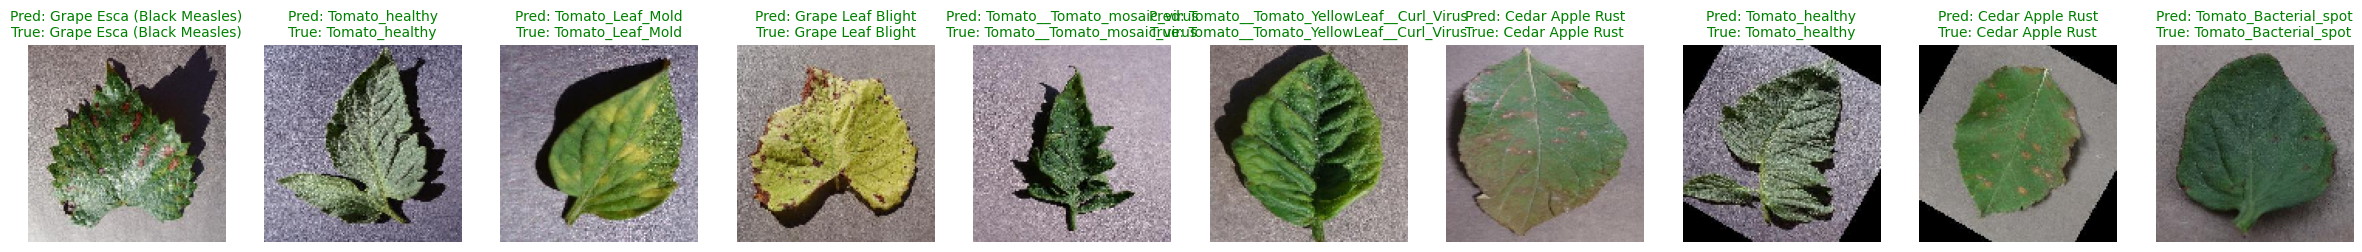

In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Select 5 random indices from the validation dataset
random_indices = random.sample(range(len(val_generator.filepaths)), 10)

# Create subplots
fig, axes = plt.subplots(1, 10, figsize=(30, 8))

for i, idx in enumerate(random_indices):
    # Load image
    img_path = val_generator.filepaths[idx]
    img = image.load_img(img_path, target_size=(128, 128))

    # Preprocess image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict class
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]  # Get predicted label

    # Get true class
    true_class_idx = val_generator.classes[idx]
    true_class = class_names[true_class_idx]

    # Display image with prediction
    axes[i].imshow(img)
    axes[i].axis("off")

    # Set title with color indication (Green = Correct, Red = Incorrect)
    title_color = "green" if predicted_class == true_class else "red"
    axes[i].set_title(f"Pred: {predicted_class}\nTrue: {true_class}", fontsize=10, color=title_color)

# Show the plot
plt.show()


enter path:/content/test/Apple Healthy/7c1289d0-4fe5-478c-a9f4-5d94b461d7bf___RS_HL 7970.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


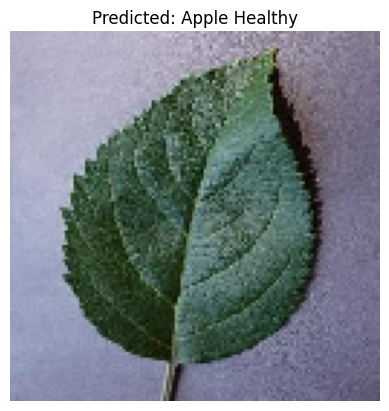

In [26]:
#Load external image
external_img_path = input('enter path:')  # Change this to your test image path

# Load and preprocess image
img = image.load_img(external_img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]

# Display Image with Prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}")
plt.show()

In [27]:
# Save in the new Keras format
model.save("plant_disease_model.keras")